# 텍스트 요약 : 뉴스기사 요약하기   

## - 목차   

1. 데이터 수집   
2. 데이터 전처리 (추상적 요약)   
3. 모델 설계   
4. 어텐션 메커니즘 사용 (추상적 요약)  
5. 모델 훈련
6. 모델 테스트 : 실제 결과와 요약문 비교 (추상적 요약)   
7. Summa 이용한 추출적 요약   
- 프로젝트 결과

## 1. 데이터 수집

In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
data.sample(10)

,headlines,text
61748,PokÃÂ©mon Go maker announces Harry Potter AR ...,Maker of the augmented reality (AR) game PokÃ...
55169,Savings through Aadhaar-based DBT expected to ...,Finance Minister Arun Jaitley on Saturday said...
79988,Air India plans voluntary retirement scheme fo...,Air India is drawing up a proposal to offer vo...
85837,I don't want to sing for any superstar: Diljit...,Singer Diljit Dosanjh has said he doesn't want...
33653,"Would love to do a biopic on Rajesh Khanna, sa...",Pulkit Samrat has said he would love to do a b...
62245,26 teenage girls found dead in Mediterranean Sea,Italy has launched an investigation into the d...
93253,"People in Mumbai clean 20,000 kg of trash",Nearly 100 residents of Kandivali in Mumbai ca...
24947,Misinterpreted: Minister who linked lynching t...,A day after he said the Alwar lynching inciden...
90966,BJP workers forge Jayant Sinha's sign to dupe ...,BJP workers in Union Minister Jayant Sinha's c...
42019,Too early to give prenuptial agreement legal b...,The government has said it is too early to giv...


- 추상적 요약을 하는 경우에는 text를 본문, headlines를 이미 요약된 데이터로 모델을 학습하면 됨.
- 추출적 요약을 하는 경우에는 오직 text열만을 사용해야 함.

In [3]:
print('샘플 수  : ', (len(data)))

샘플 수  :  98401


In [4]:
print('headlines first data : \n', data.loc[0]['headlines'])
print('text first data : \n', data.loc[0]['text'])

headlines first data : 
 upGrad learner switches to career in ML & Al with 90% salary hike
text first data : 
 Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.


## 2. 데이터 전처리 (추상적 요약)

### 2.1 중복값, 결측치 제거

In [5]:
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [6]:
data.drop_duplicates(subset = ['text'], inplace = True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 98360


In [7]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


### 2.2 텍스트 정규화 및 불용어 제거

In [8]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ",len(contractions))

정규화 사전의 수:  120


In [9]:
#데이터 전처리 함수

def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() #텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text #<br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) #괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) #쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) #약어 정규화
    sentence = re.sub(r"'s\b","", sentence) #소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) #영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) #m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    
    # 불용어 미제거 (Summary)
    #상대적으로 문장 길이가 짧은 Summary 전처리할 때는 호출하지 않음.
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
        
    return tokens

In [10]:
#데이터 전처리 함수 작동 확인
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print(preprocess_sentence(temp_text))

#Text의 경우에는 불용어를 제거하고, Summary의 경우에는 불용어를 제거하지 않음.
print(preprocess_sentence(temp_summary, False)) 

everything bought great infact ordered twice third ordered wasfor mother father
great way to start the day


In [11]:
### 멀티 프로세싱

import multiprocessing as mp  
from multiprocessing import Pool
import numpy as np
import time
from functools import partial  #map을 할 때 함수에 여러 인자를 넣어줄 수 있도록 함.

start = time.time()

#num_cores 만큼 쪼개진 데이터를 전처리하여 반환
def appendTexts(sentences, remove_stopwords):
  texts = []
  for s in sentences:
    texts += preprocess_sentence(s, remove_stopwords),
  return texts

def preprocess_data(data, remove_stopwords=True):
  start_time = time.time()
  num_cores = mp.cpu_count()  #컴퓨터의 코어 수

  text_data_split = np.array_split(data, num_cores)  #코어 수만큼 데이터를 배분하여 병렬적으로 처리
  pool = Pool(num_cores)

  #각자 작업한 데이터를 하나로 합쳐줌.
  processed_data = np.concatenate(pool.map(partial(appendTexts, remove_stopwords=remove_stopwords), text_data_split))
  pool.close()
  pool.join()
  print(time.time() - start_time, " seconds")
  return processed_data

clean_text = preprocess_data(data['text'])
print(clean_text[:5])

#Summary에 대해서 전처리 함수를 호출해 줄 때는, 불용어 제거를 수행하지 않는다는 의미에서 두 번째 인자로 False 넣음.
clean_headlines = preprocess_data(data['headlines'], remove_stopwords=False) 
print(clean_headlines[:5])

185.0547275543213  seconds
['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers'
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit'
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history'
 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers op

In [12]:
#전처리 후 빈 샘플이 생겼는지 확인.
#전처리 과정에서 문장의 모든 단어가 사라지는 경우가 있음.
#빈 샘플이 있으면 모두 Null로 대체.

data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

data.isnull().sum()

headlines    0
text         0
dtype: int64

In [13]:
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 98360


### 2.3 샘플 최대 길이 정하기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


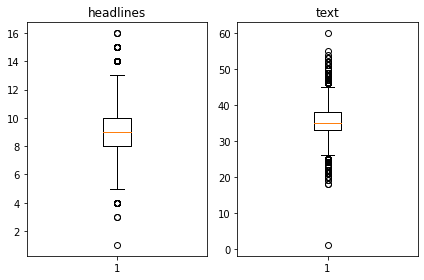

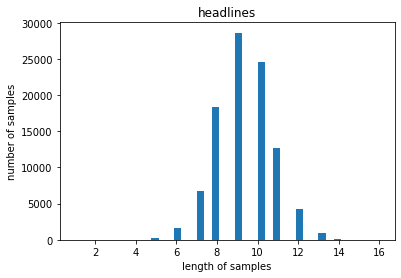

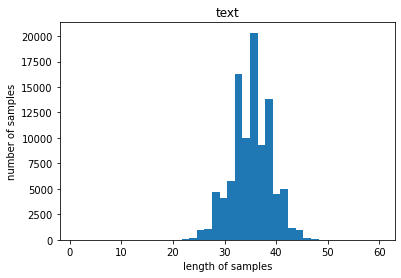

In [14]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(summary_len)
plt.title('headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('headlines')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

- 텍스트의 경우 최소 길이가 1, 최대 길이는 60, 평균 길이는 35로 그래프로 봤을 때 대체적으로 20 ~ 50 사이에 분포해 있음을 알 수 있다.
- 헤드라인(요약)의 경우 최소 길이는 1, 최대 길이는 16, 평균 길이가 9로 그래프로 봤을 때 4 ~ 14 사이에 분포해 있음을 알 수 있다. 
- 위의 결과를 바탕으로 텍스트의 길이와 헤드라인의 적절한 최대 길이를 임의로 정할 수 있다.

In [15]:
#위의 결과를 바탕으로 정한 임의의 최대 길이
text_max_len = 45
headlines_max_len = 13

In [16]:
#위의 임의로 정한 길이들이 얼마나 객관적인지 통계로 확인

def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [17]:
#임의의 길이가 몇%의 샘플까지 포함하는지 볼 수 있음.
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 45 이하인 샘플의 비율: 0.9967771451809678
전체 샘플 중 길이가 13 이하인 샘플의 비율: 0.9981699877999186


- 비율을 봤을 때 임의로 정한 최대 길이가 나쁘지 않았음을 알 수 있음.

In [18]:
#정해진 길이에 맞춰 잘라내면 샘플들이 내용이 조금이라도 망가지기 때문에
#자르는 것이 아닌 정해진 길이보다 길면 제외하는 방법으로 데이터 정제할 것.

data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 97863


### 2.4 시작 토큰과 종료 토큰 추가
- 시작 토큰은 sostoken, 종료 토큰은 eostoken이라 임의로 정하고 앞, 뒤로 추가함.
- 디코더의 입력에 해당하면서 시작 토큰이 맨 앞에 있는 문장의 이름을 decoder_input
- 디코더의 출력 또는 레이블에 해당되면서 종료 토큰이 맨 뒤에 붙는 문장의 이름을 decoder_target이라고 이름을 정함.


In [19]:
#headlines 데이터에 시작 토큰과 종료 토큰을 추가.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


In [20]:
#인코더의 입력, 디코더의 입력 후 레이블을 다시 numpy 타입으로 저장.

#인코더의 입력
encoder_input = np.array(data['text']) 

#디코더의 입력
decoder_input = np.array(data['decoder_input']) 

#디코더의 레이블
decoder_target = np.array(data['decoder_target']) 

### 2.5 데이터셋 분리
- 훈련 데이터와 테스트 데이터 분리.
- 직접 코딩을 통해 분리할 예정.

In [21]:
#encoder_input과 크기, 형태가 같은 순서가 섞인 정수 시퀀스를 형성.
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)
print('indices len :', len(indices))

[46844 24653 21980 ...  5902 72806 57833]
indices len : 97863


In [22]:
#위의 정수 시퀀스를 이용해 데이터 샘플 순서를 정의하여 샘플을 섞음.
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [23]:
#섞은 데이터를 8:2의 비율로 분리
#전체 데이터의 크기에서 0.2를 곱해 테스트 데이터의 크기를 정의.

n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19572


In [24]:
#위에서 정의한 테스트 데이터의 개수를 이용해 전체 데이터를 양분

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78291
훈련 레이블의 개수 : 78291
테스트 데이터의 개수 : 19572
테스트 레이블의 개수 : 19572


### 2.6 단어 집합(vocabulary) 생성 및 정수 인코딩
- 단어 집합 : 각 단어에 고유한 정수 맵핑
- Keras의 토크나이저를 사용하면, 입력된 훈련 데이터로부터 단어 집합을 만들 수 있음.

#### - 텍스트 단어 집합 만들기

In [25]:
#토크나이저 정의
src_tokenizer = Tokenizer() 

#입력된 데이터로부터 단어 집합 생성
src_tokenizer.fit_on_texts(encoder_input_train) 

In [26]:
#빈도수가 낮은 단어들은 훈련 데이터에서 제외하고 진행.

#등장 빈도수가 7회 미만인 단어들이 데이터에서 얼마나 차지하는지 확인
#src_tokenizer.word_counts.items()로 통계적인 정보를 얻을 수 있음.

threshold = 7
total_cnt = len(src_tokenizer.word_index) #단어의 수
rare_cnt = 0 #등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 #훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 #등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

#단어와 빈도수의 쌍(pair)을 key와 value로 받음.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    #단어의 등장 빈도수가 threshold보다 작을 때
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69257
등장 빈도가 6번 이하인 희귀 단어의 수: 47128
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22129
단어 집합에서 희귀 단어의 비율: 68.04799514850485
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.479532089180063


- 단어 집합(vocabulary)의 크기는 약 7만임.
- 등장 빈도가 threshold 값인 7회 미만, 즉, 6회 이하인 단어들은 단어 집합에서 약 68%를 차지함.
- 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 적은 수치인 약 3.5%임.
- 등장 빈도가 6회 이하인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거하는 것이 좋음.

In [27]:
#위에서 제외한 단어 집합 크기를 약 2만 2천여개로 계산했는데 이와 비슷한 값으로 단어 집합 크기를 제한할 것.
#토크나이저 정의 시 num_words의 값을 정하면 단어 집합의 크기를 제한할 수 있음.

src_vocab = 22000

#단어 집합의 크기를 22,000으로 제한
src_tokenizer = Tokenizer(num_words=src_vocab) 

#단어 집합 재생성.
src_tokenizer.fit_on_texts(encoder_input_train) 

In [28]:
#텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

#잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[2604, 2724, 18277, 764, 3, 13, 19, 198, 1532, 9109, 3601, 6170, 1219, 5, 8141, 80, 1902, 88, 28, 267, 5315, 18278, 228, 198, 1219, 18277, 1532, 1500, 855, 29, 3, 19, 1902, 592], [132, 708, 2754, 313, 837, 3211, 3982, 2466, 5259, 440, 4834, 107, 1450, 440, 3295, 107, 5925, 15963, 908, 2466, 263, 3982, 7776, 794, 1670, 2228, 949, 108, 837, 1484, 1257, 3128, 9275, 432], [653, 222, 252, 97, 124, 5467, 2652, 970, 3423, 695, 105, 196, 309, 1, 516, 1, 2618, 927, 759, 4, 1116, 271, 5806, 1275, 1046, 653, 277, 11234, 1]]


- texts_to_sequences()는 생성된 단어 집합에 기반하여 입력으로 주어진 텍스트 데이터의 단어들을 모두 정수로 변환하는 정수 인코딩을 수행.
- 22,000이 넘는 숫자들은 정수 인코딩 후에는 데이터에 존재하지 않게 됨.

#### - headlines 단어 집합 만들기

In [29]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [30]:
hreshold = 6
total_cnt = len(tar_tokenizer.word_index) #단어의 수
rare_cnt = 0 #등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 #훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 #등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

#단어와 빈도수의 쌍(pair)을 key와 value로 받음.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    #단어의 등장 빈도수가 threshold보다 작을 때
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29989
등장 빈도가 6번 이하인 희귀 단어의 수: 20475
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9514
단어 집합에서 희귀 단어의 비율: 68.27503417919904
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.305387809313382


- 단어 집합(vocabulary)의 크기는 약 3만임.
- 등장 빈도가 threshold 값인 6회 미만, 즉, 5회 이하인 단어들은 단어 집합에서 약 68%를 차지함.
- 전체 등장 빈도에서 희귀 단어 등장 빈도 비율은 약 5.3%임.
- 등장 빈도가 5회 이하인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거하는 것이 좋음.

In [31]:
#위에서 제외한 단어 집합 크기를 약 9천5백개로 계산했는데 이와 비슷한 값으로 단어 집합 크기를 제한할 것.
tar_vocab = 9500
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

#텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

#잘 변환되었는지 확인
print('input : ')
print('input ',decoder_input_train[:5])
print('target : ')
print('decoder ',decoder_target_train[:5])

input : 
input  [[1, 61, 26, 313, 4, 1670, 431, 61, 26, 29, 108], [1, 410, 1818, 53, 4983, 1965, 5392, 4, 1168, 5890], [1, 362, 396, 72, 466, 179, 18, 76, 338, 81, 323], [1, 2837, 1045, 1520, 1392, 1929, 1348, 9, 3895], [1, 8751, 3086, 8172, 292, 7668, 118, 1255, 2626]]
target : 
decoder  [[61, 26, 313, 4, 1670, 431, 61, 26, 29, 108, 2], [410, 1818, 53, 4983, 1965, 5392, 4, 1168, 5890, 2], [362, 396, 72, 466, 179, 18, 76, 338, 81, 323, 2], [2837, 1045, 1520, 1392, 1929, 1348, 9, 3895, 2], [8751, 3086, 8172, 292, 7668, 118, 1255, 2626, 2]]


- 전체 데이터에서 빈도수가 낮은 단어가 삭제되었다는 것은 빈도수가 낮은 단어만으로 구성되었던 샘플들은 이제 빈(empty) 샘플이 되었을 가능성이 있음.
- 평균 길이가 짧았던 headline은 더욱 심할 것.
- decoder_input에는 sostoken 또는 decoder_target에는 eostoken이 추가된 상태이고, 이 두 토큰은 모든 샘플에서 등장하므로 빈도수가 샘플 수와 동일하게 매우 높으므로 단어 집합 제한에도 삭제되지 않음. 그래서 이제 길이가 0이 된 요약문의 실제 길이는 1로 나올 것.

In [32]:
#요약문에서 길이가 0이 된 샘플들의 인덱스를 받아 
#훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 1인 경우의 인덱스를 
#각각 drop_train과 drop_test에 라는 변수에 저장 후 이 샘플들을 모두 삭제.

drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1
삭제할 테스트 데이터의 개수 : 0


/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


훈련 데이터의 개수 : 78290
훈련 레이블의 개수 : 78290
테스트 데이터의 개수 : 19572
테스트 레이블의 개수 : 19572


### 2.7 패딩하기

In [34]:
#서로 다른 길이의 샘플들을 병렬 처리하기 위해 같은 길이로 맞춰줌.
#최대 길이보다 짧은 데이터들은 뒤의 공간에 숫자 0을 넣어 최대 길이로 길이를 맞춤.

encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

## 3. 모델 설계

In [35]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


#인코더 설계 시작
#임베딩 벡터의 차원은 128로 정의하고, hidden state의 크기를 256으로 정의
embedding_dim = 128
hidden_size = 256   # hidden state는 LSTM에서 얼만큼의 수용력(capacity)를 가질지를 정하는 파라미터
                    #이 파라미터는 LSTM의 용량의 크기나, LSTM에서의 뉴런의 개수로 이해하면 됨.
#인코더
encoder_inputs = Input(shape=(text_max_len,))

#인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

#인코더의 LSTM은 총 3개의 층으로 구성해서 모델의 복잡도를 높임.
#인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [36]:
#디코더의 임베딩 층과 LSTM을 설계하는 것은 인코더와 거의 동일함.
#LSTM 입력 정의 시 initial_state의 인자값으로 인코더의 hidden state와 ceel state의 값을 넣어줘야 함.

#디코더 설계
decoder_inputs = Input(shape=(None,))

#디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

#디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [37]:
#디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

#모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 45, 128)      2816000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 45, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

- 디코더의 출력층에서는 Summary의 단어장인 tar_vocab의 수많은 선택지 중 하나의 단어를 선택하는 다중 클래스 분류 문제를 풀어야하기 때문에 Dense의 인자로 tar_vocab을 주고, 활성화 함수로 소프트맥스 함수를 사용함.

- 지금까지 설계한 것은 인코더의 hidden state와 cell state를 디코더의 초기 state로 사용하는 가장 기본적인 seq2seq임.

## 4. 어텐션 메커니즘 (추상적 요약)
- 디코더의 출력층을 설계를 살짝 바꿔서 성능을 높일 수 있는 방법이지만 또 다른 새로운 신경망을 설계해야 한다는 뜻이기도 함.

In [38]:
#깃허브에 공개 되어 있는 어텐션 함수 다운
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [39]:
###디코더의 출력층 수정

# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 45, 128)      2816000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 45, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

- 위의 코드는 인코더의 hidden state들과 디코더의 hidden state들을 어텐션 함수의 입력으로 사용하고, 어텐션 함수가 리턴한 값을 예측 시에 디코더의 hidden state와 함께 활용하는 형태로 작동함.

## 5. 모델 훈련

In [40]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

#val_loss(검증 데이터의 손실)을 관찰하다가, 
#검증 데이터의 손실이 줄어들지 않고 증가하는 현상이 2회(patience=2) 관측되면 학습을 멈추도록 설정
es = EarlyStopping(monitor='val_loss', mode='min', patience=2, verbose=1)

history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
306/306 [==============================] - 236s 735ms/step - loss: 5.5862 - val_loss: 4.8140
Epoch 2/50
306/306 [==============================] - 223s 730ms/step - loss: 4.7464 - val_loss: 4.4315
Epoch 3/50
306/306 [==============================] - 221s 722ms/step - loss: 4.3677 - val_loss: 4.1709
Epoch 4/50
306/306 [==============================] - 221s 721ms/step - loss: 4.1048 - val_loss: 3.9941
Epoch 5/50
306/306 [==============================] - 222s 726ms/step - loss: 3.8985 - val_loss: 3.8706
Epoch 6/50
306/306 [==============================] - 221s 721ms/step - loss: 3.7253 - val_loss: 3.7657
Epoch 7/50
306/306 [==============================] - 220s 720ms/step - loss: 3.5900 - val_loss: 3.6765
Epoch 8/50
306/306 [==============================] - 221s 721ms/step - loss: 3.4653 - val_loss: 3.6156
Epoch 9/50
306/306 [==============================] - 221s 724ms/step - loss: 3.3634 - val_loss: 3.5531
Epoch 10/50
306/306 [==============================] - 220s 720m

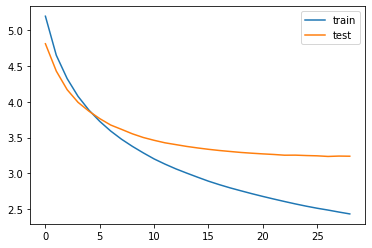

In [41]:
#훈련 데이터의 손실과 검증 데이터의 손실이 줄어드는 과정 시각화
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## 6. 모델 테스트 : 실제 결과와 요약문 비교 (추상적 요약)

### 6.1 인퍼런스 모델 구현하기

In [42]:
### 필요한 사전 3개 준비

#원문 단어 집합에서 정수 -> 단어를 얻음
src_index_to_word = src_tokenizer.index_word

#요약 단어 집합에서 단어 -> 정수를 얻음
tar_word_to_index = tar_tokenizer.word_index

#요약 단어 집합에서 정수 -> 단어를 얻음
tar_index_to_word = tar_tokenizer.index_word 

- seq2seq는 훈련할 때와 실제 동작할 때(인퍼런스 단계)의 방식이 다르므로 그에 맞게 모델 설계를 별개로 진행해야 함.
- 정답 문장이 없는 인퍼런스 단계에서는 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 하기 때문에 부득이하게 인퍼런스를 위한 모델 설계를 별도로 해주어야 함.
- 때문에 인코더 모델과 디더 모델을 분리해서 설계함.

In [43]:
#인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

#이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

#문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
#훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [44]:
### 어텐션 메커니즘 사용하는 출력층 설계

#어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

#디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

#최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [45]:
### 인퍼런스 단계에서 단어 시퀀스를 완성하는 함수

def decode_sequence(input_seq):
    #입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    #<SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: #stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        # <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        #길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        #상태 업데이트
        e_h, e_c = h, c

    return decoded_sentence

### 6.2 원문과 요약문 비교

In [46]:
### 원문의 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수

def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

#요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

- Text의 정수 시퀀스에서는 패딩을 위해 사용되는 숫자 0을 제외하고 Summary의 정수 시퀀스에서는 숫자 0, 시작 토큰의 인덱스, 종료 토큰의 인덱스를 출력에서 제외하도록 만들어야 함.

In [55]:
#실제 요약과 예측된 요약 비교
for i in range(10):
    print("원문 : \n ", seq2text(encoder_input_test[i]))
    print("실제 요약 : \n ", seq2summary(decoder_input_test[i]))
    print("예측 요약 : \n ", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : 
  three twelve boys trapped cave northern thailand days granted thai citizenship wednesday boys despite born thailand lack citizenship deprived basic benefits rights three applied citizenship cave incident 
실제 요약 : 
  boys rescued from thai cave granted citizenship 
예측 요약 : 
   thai cave rescued from thai cave to rescue boys


원문 : 
  nasa mars reconnaissance orbiter spotted space agency opportunity rover dust storm red planet opportunity last communicated june operating since nasa oldest active rover nasa hoping solar powered rover contact earth batteries charged exposure sunlight 
실제 요약 : 
  nasa mars spots silent rover as dust storm clears 
예측 요약 : 
   nasa rover rover on mars days to mars


원문 : 
  us president donald trump told friends got lot richer hours signed tax cut bill proposed us biggest tax overhaul years law friday report claimed legislation estimated cost us lakh crore cuts corporate tax rate 
실제 요약 : 
  trump told friends they got lot richer after tax cut report 

## 7. Summa 이용한 추출적 요약
- 패키지 Summa에서는 추출적 요약을 위한 모듈인 summarize를 제공하고 있음.
- text (str) : 요약할 테스트.
- ratio (float, optional) – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값
- words (int or None, optional) – 출력에 포함할 단어 수.
- split (bool, optional) – True면 문장 list / False는 조인(join)된 문자열을 반환.
- Summa의 summarize는 문장 토큰화를 별도로 하지 않더라도 내부적으로 문장 토큰화를 수행.

In [50]:
import urllib.request

urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
orig_data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [58]:
import requests
from summa.summarizer import summarize

for i in range(10):
    print("원문 : \n ", orig_data['text'][i])
    print("실제 요약 : \n ", orig_data['headlines'][i])
    print("예측 요약 : \n ", summarize(orig_data['text'][i], ratio=0.5))
    print("\n")

원문 : 
  Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
실제 요약 : 
  upGrad learner switches to career in ML & Al with 90% salary hike
예측 요약 : 
  upGrad's Online Power Learning has powered 3 lakh+ careers.


원문 : 
  Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
실제 요약 : 
  Delhi techie wins free food from Swiggy for one year on CRED
예측 요약 : 
  Users get one CRED coin per

---

# - 프로젝트 정리

### 1. 모델 :   

- 모델을 학습 시켰을 때 loss는 2.3970, val_loss는 3.2395로 생각보다 loss 값들이 높게 나왔다. 
- 모델의 성능을 개선하기 위해서는 seq2seq와 어텐션의 자체의 조합을 좀 더 좋게 수정하는 방법도 있으며 빔 서치(beam search), 사전 훈련된 워드 임베딩(pre-trained word embedding), 또는 인코더 - 디코더 자체의 구조를 새로이 변경한 하는 트랜스포머(Transformer)와 같은 여러 개선 방안들이 존재한다고 한다.
- 모델을 훈련시키는데 시간이 너무 오래 걸려서 전부 시도해보진 못했지만 시간이 된다면 전부 시도 해 봐도 좋을 것 같다.   



### 2. Abstractive Summarization :   
1)

원문 : 
  three twelve boys trapped cave northern thailand days granted thai citizenship wednesday boys despite born thailand lack citizenship deprived basic benefits rights three applied citizenship cave incident    
  
실제 요약 : 
  boys rescued from thai cave granted citizenship    
  
예측 요약 : 
   thai cave rescued from thai cave to rescue boys   
   
- 예측된 요약과 실제 헤드라인을 비교하면 위와 같이 키워드를 잘 찾아낸 예측 요약 문장도 있다.    

2)

원문 : 
  nasa mars reconnaissance orbiter spotted space agency opportunity rover dust storm red planet opportunity last communicated june operating since nasa oldest active rover nasa hoping solar powered rover contact earth batteries charged exposure sunlight    
  
실제 요약 : 
  nasa mars spots silent rover as dust storm clears    
  
예측 요약 : 
   nasa rover rover on mars days to mars
   
- 위와 같이 키워드 단어는 잘 잡아냈지만 제대로 된 문장을 만들지 못하고 엉뚱한 내용의 예측 요약이 나오기도 했다.    
   
   
타겟이 뉴스의 헤드라인이라 축약어가 많아 모델 학습이 제대로 되지 않았을 경우도 있을 것 같다. 또, 본문에서는 사용하지 않았던 단어를 헤드라인에서 사용하면서 원문과 관련이 없는 단어를 포함한 예측 요약 문장이 만들어지기도 했다.

### 3. Extractive Summarization :   
   
원문 : 
  India recorded their lowest ODI total in New Zealand after getting all out for 92 runs in 30.5 overs in the fourth ODI at Hamilton on Thursday. Seven of India's batsmen were dismissed for single-digit scores, while their number ten batsman Yuzvendra Chahal top-scored with 18*(37). India's previous lowest ODI total in New Zealand was 108.   
  
실제 요약 : 
  India get all out for 92, their lowest ODI total in New Zealand   
  
예측 요약 : 
  India's previous lowest ODI total in New Zealand was 108.   
  

- 원문에서 문장을 가져오기 때문인지 Abstractive Summarization보다 예측 문장이 훨씬 매끄럽게 만들어졌다. 하지만 겉으로만 제대로 된 문장처럼 보일 뿐 실제 요약을 잘 했는지를 보면 아닌 문장도 많다.  

- 부가적인 설명이 많아 실제 요약 문장보다 예측 요약 문장이 더 긴 경우가 많으며, 내용을 제대로 요약한 것이 맞나 싶을 정도로 전혀 다른 이야기를 하는 예측 요약 문장도 있다.   

- 위와 같이 요약 해야 할 키워드를 잘못 잡아서 아예 다른 문장을 내 놓는 경우도 많았다.